# Deep Learning Applications

This lesson assumes students are 
- Strong on Data Science fundamentals
- Familiar with Deep Learning theory
- Comfortable with Sci-Kit Learn

At the end of this lesson you should be able to
- Use Keras to build models that tackle many common applications
- Modify existing "cookie-cutter" models to tailor them for specific tasks
- Interact with Keras and Tensorflow where needed

We can't cover everything so keep these resources handy and refer back to them when you need more details
- [Keras documentation](https://keras.io/)
- [Tensorflow documentation](https://www.tensorflow.org/api_docs/)
- [Official Keras examples](https://github.com/keras-team/keras/tree/master/examples) dozens of examples. just about everything you could need
- [Deep Learning Book](http://www.deeplearningbook.org/) Free and just about the best coverage of the theory behind Deep Learning around

In [1]:
%pylab inline
import pandas as pd 
import keras

IMSIZE = [224,224]
BATCH = 32

Populating the interactive namespace from numpy and matplotlib


/home/soph/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Deep Learning approaches

First, recall from previous lessons the essential parts of any neural network

- A chain of differentiable functions that
  - Includes trainable parameters.
  - Could, with the right parameters, perform the operation you're looking for.
  - Includes [non-linearities](https://stackoverflow.com/questions/9782071/why-must-a-nonlinear-activation-function-be-used-in-a-backpropagation-neural-net).
- A [loss function](http://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html) that puts a number on "does the network do what I want it to?".
  - Regression (guess the right number): Mean Squared Error, Mean Average Error
  - Categorization (guess the right class): Categorical Cross-Entropy
  - Multi-Label classification (guess which labels apply): Binary Cross-Entropy

Given these two pieces, we use backpropogation to optimize our trainable function to produce better and better output at each step. 


We will learn two methods for accomplishing this:

## 1 The Tensorflow method

Here, we will build the "function" that our model computes piece-by-piece. We'll create every variable, define all the operations that connect them, and "manually" feed data into the function each time.

Here we'll accomplish two things. First, we'll take some of the mystery out of neural nets. This is meant to be a short learning experience. If you wish to include neural nets in your project **it is not recommended to start with this method**. In general, this is an approach you may wish to revisit if, after using the second method, you wish to have more direct control over how your model is built.

## 2 The Keras method 

Here, we use high-level building blocks to quickly compose complex-yet-powerful networks. Keras gives you access to some of the most advanced, difficult to implement architectures without requiring you to implement them by hand. **This is where most neural net projects should start**.

Again, just for complete clarity, these methods are taught in the current order so that, when we arrive the Keras approach, we understand what Keras is doing under the hood. 

## Data prep

We will focus on image recognition, a task Deep Learning models have excelled in in recent years. We will use data from the [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats/data) Kaggle competition. Follow the link above and download the `train.zip` file under data. Unzip the file and note the location below. 

First we will pull out 1,000 images each for our train, validation, and test sets. This is necessary to execute these models on most laptop computers. If you have access to a more powerful computer or are happy to wait, feel free to adjust the size of the sets.

**TODO:** In the below cell, set the variable dvc_path to the location where you downloaded the dataset. Then run the following cells to create the train, validation, and test set and to visualize a sample of the images. 

In [2]:
dvc_path = ""
split_sizes = {"train": 1000, "validation":1000, "test":1000}

In [3]:
import glob, shutil, os

labeled_files = set(glob.glob(dvc_path+"/train/**.jpg", recursive=True))
cat_files = {f for f in labeled_files if "cat" in f}
dog_files = labeled_files - cat_files

print(f"found {len(labeled_files)} labeled files, {len(cat_files)} of cats and {len(dog_files)} of dogs")

shutil.rmtree(dvc_path+"/split", ignore_errors=True)

for split in split_sizes:
    print(f"moving {split_sizes[split]} files for {split}")
    n = split_sizes[split]//2
    os.makedirs(f"{dvc_path}/split/{split}/cat", exist_ok=True)
    os.makedirs(f"{dvc_path}/split/{split}/dog", exist_ok=True)
    
    new_cats = set(np.random.choice(list(cat_files), size=n, replace=False))
    for new_cat_file in new_cats:
        _, fname = new_cat_file.split("train/")
        shutil.copy(new_cat_file, f"{dvc_path}/split/{split}/cat/{fname}")
    cat_files = cat_files - new_cats
        
    new_dogs = set(np.random.choice(list(dog_files), size=n, replace=False))
    for new_dog_file in new_dogs:
        _, fname = new_dog_file.split("train/")
        shutil.copy(new_dog_file, f"{dvc_path}/split/{split}/dog/{fname}")
    dog_files = dog_files - new_dogs

found 25000 labeled files, 12500 of cats and 12500 of dogs
moving 1000 files for train
moving 1000 files for validation
moving 1000 files for test


In [4]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255)

In [5]:
def plot_images(x, y, **kwargs):
    n_pix = int(np.sqrt(np.prod(x.shape[1:3]))) #assumes images are square
    im_indices = np.random.choice(x.shape[0], 36, replace=False)
    fig, axes = subplots(nrows=6,ncols=6, figsize=(10,10), sharex=True, sharey=True, frameon=False)
    for i,ax in enumerate(axes.flat):
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        curr_i = im_indices[i]
        ax.imshow(x[curr_i].reshape(n_pix,n_pix, 3), aspect="auto", **kwargs)
        if y[curr_i]==0:
            ax.text(10,20,'cat', fontdict={"backgroundcolor": "gray","color": "white" })
        else:
            ax.text(10,20,'dog', fontdict={"backgroundcolor": "gray","color": "white" })
#         ax.set_title(title)
        ax.axis('off')
    plt.tight_layout(h_pad=0, w_pad=0)

Found 1000 images belonging to 2 classes.


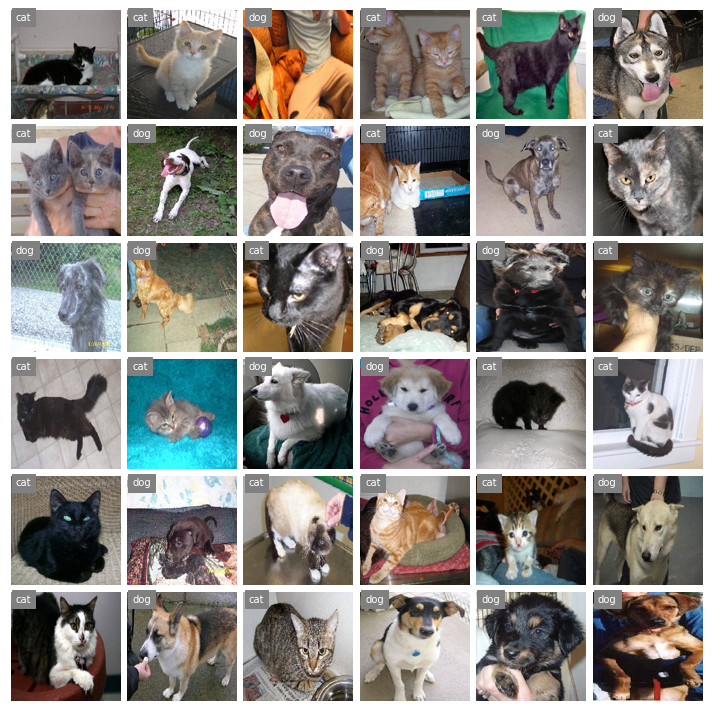

In [6]:
plot_gen = datagen.flow_from_directory(
    directory=dvc_path+"/split/train",
    target_size=IMSIZE,
    batch_size=36,
    class_mode='binary'
)

x,y = next(plot_gen)

plot_images(x, y, interpolation="spline16")

# The Tensorflow method: Deep Learning the hard(er) way

In [7]:
import tensorflow as tf
from sklearn import datasets, model_selection, preprocessing
tf.__version__

'1.5.0'

In [8]:
TF_IMSIZE = [50,50]

datagen = ImageDataGenerator(rescale=1/255, samplewise_center=True, samplewise_std_normalization=True)

train_gen = datagen.flow_from_directory(
    directory=dvc_path+"/split/train",
    target_size=TF_IMSIZE,
    batch_size=BATCH,
)

val_gen = datagen.flow_from_directory(
    directory=dvc_path+"/split/validation",
    target_size=TF_IMSIZE,
    batch_size=1000,
)

Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
# Network Parameters
n_hidden_1 = 64 # 1st layer number of neurons
n_hidden_2 = 32 # 2nd layer number of neurons
num_input = np.prod(TF_IMSIZE)*3 #
num_classes = 2 # 

# Placeholders are not trainable (this is our input and output)
X = tf.placeholder("float", [None] + TF_IMSIZE + [3])
X_flat = tf.contrib.layers.flatten(X)
Y = tf.placeholder("float", [None, num_classes])

Variables **are** trainable. Below, we define all the varaibles we'll use.

Pay attention here to how the dot product affects dimensions. I'll use the following notation to indicate that $A$ is an array with 100 elements along the first dimension and 50 along the second. In other words `A.shape == (100, 50)`.

$ A_{[100 \times 50]} \cdot B = C $

We need to line up the dimensions of our variables such that the last dimension of $A$ matches the first dimension of $B$. Also, keep in mind that $C$, the output is going to have a shape based on the first dimension of $A$ and the last dimension of $B$.

$ A_{[100 \times 50]} \cdot B_{[50 \times 25]} = C_{[100 \times 25]} $

In [10]:
# placing them in a dictionary is helpful for keeping organized
# but these are just python variables.
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_classes]))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

In [11]:
# Now we define the operations we'll use to construct
# the output from our inputs and trainable parameters

# First hidden fully connected layer
layer_1 = tf.matmul(X_flat, weights['h1']) + biases['b1']

# Second hidden fully connected layer
layer_2 = tf.matmul(layer_1, weights['h2']) + biases['b2']

# Output fully connected layer with a neuron for each class
logits = tf.matmul(layer_2, weights['out']) + biases['out']

# Is something missing here? What?

In [12]:
learning_rate = 0.0001

# Define the loss and optimizer
# recall that cross-entropy loss is what we use for most categorization problems
loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y)
loss_op = tf.reduce_mean(loss)

# The optimizer uses gradient descent and the backprop algorithm
# Most of these are just variations on Stochastic Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [13]:
# Parameters
num_steps = 350 # roughly 10 epochs
display_step = int(num_steps//20)

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)
    loss = []
    acc = []

    for step in range(1, num_steps+1):
        batch_x, batch_y = next(train_gen)
        # Run optimization op (backprop)
        _, train_loss, train_acc = sess.run([train_op, loss_op, accuracy], feed_dict={X: batch_x, Y: batch_y})
        loss.append(train_loss)
        acc.append(train_acc)
        if step % display_step == 0:
            
            x_val, y_val = next(val_gen)
            val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: x_val,
                                                                 Y: y_val})
            print(f"Step {step}, Train: Loss={np.mean(loss):.4f}, Acc={np.mean(acc):.2%}"
                  f"| Val: Loss={val_loss:.4f}, Acc={val_acc:.2%}")
            loss = []
            acc = []

    print("Optimization Finished!")

Step 17, Train: Loss=1542.8374, Acc=48.90%| Val: Loss=1016.1864, Acc=54.50%
Step 34, Train: Loss=1044.3112, Acc=50.37%| Val: Loss=832.2003, Acc=55.70%
Step 51, Train: Loss=835.4045, Acc=55.88%| Val: Loss=699.4717, Acc=53.90%
Step 68, Train: Loss=783.7738, Acc=46.51%| Val: Loss=574.8193, Acc=53.80%
Step 85, Train: Loss=568.1284, Acc=52.21%| Val: Loss=486.8083, Acc=55.80%
Step 102, Train: Loss=489.5629, Acc=52.94%| Val: Loss=418.2968, Acc=55.30%
Step 119, Train: Loss=407.8911, Acc=51.47%| Val: Loss=365.1964, Acc=51.90%
Step 136, Train: Loss=354.8118, Acc=48.53%| Val: Loss=312.1223, Acc=52.40%
Step 153, Train: Loss=296.8689, Acc=51.29%| Val: Loss=268.7752, Acc=55.20%
Step 170, Train: Loss=242.2033, Acc=54.41%| Val: Loss=235.0499, Acc=53.00%
Step 187, Train: Loss=205.9579, Acc=50.55%| Val: Loss=219.9262, Acc=52.80%
Step 204, Train: Loss=183.9895, Acc=56.62%| Val: Loss=199.6694, Acc=51.00%
Step 221, Train: Loss=179.6770, Acc=50.00%| Val: Loss=181.9994, Acc=51.60%
Step 238, Train: Loss=142.5

# **Exercise 1**: 

Explain what is happening here. Specifically, is anything about this network and its performance not ideal? Why?


# **Solution 1:**

- Performance is lower than what we would expect from KNN, SVMs, even MN naive bayes can do better than this!
 - We didn't add a nonlinear activation function! We'll add that next and see how it does :)
 - Fully connected networks (the simple kind that we just built) are not optimized for image data. We'll see a network that is in a moment.
- We're overfitting
  - Validation performance usually peaks around step ~2000. Then train performance increases at the expense of validation performance.
  - We'll see a few techniques for dealing with this problem.

# **Exercise 2**:

Using the above code as a starting point, try to address the problems mentioned above by keeping the two hidden layer structure but adding a non-linearity and re-training the network.

# **Solution 2 **:

There are many possible solutions here but the important thin is the addition of a nonlinear activation function when defining layer_1 and layer_2.

In [14]:
# Now we re-define our operations to include a non-linearity. Tanh!
# Parameters
learning_rate = 0.0001

# First hidden fully connected layer
layer_1 = tf.nn.elu(tf.matmul(X_flat, weights['h1']) + biases['b1'])

# Second hidden fully connected layer
layer_2 = tf.nn.elu(tf.matmul(layer_1, weights['h2']) + biases['b2'])

# Output fully connected layer with a neuron for each class
logits = tf.matmul(layer_2, weights['out']) + biases['out']

# We don't use tanh for the output because tanh is "squashing"
# meaning it only outputs values on a limited range (here [-1,1])
# We want our logits to vary freely so that our network can better
# represent extreme probabilities like 
# "this class is very very very unlikely"

# Define the loss and optimizer
# recall that cross-entropy loss is what we use for most categorization problems
loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y)
loss_op = tf.reduce_mean(loss)

# The optimizer uses gradient descent and the backprop algorithm
# Most of these are just variations on Stochastic Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [15]:
num_steps = 350 # roughly 10 epochs
display_step = int(num_steps//20)

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)
    loss = []
    acc = []

    for step in range(1, num_steps+1):
        batch_x, batch_y = next(train_gen)
        # Run optimization op (backprop)
        _, train_loss, train_acc = sess.run([train_op, loss_op, accuracy], feed_dict={X: batch_x, Y: batch_y})
        loss.append(train_loss)
        acc.append(train_acc)
        if step % display_step == 0:
            
            x_val, y_val = next(val_gen)
            val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: x_val,
                                                                 Y: y_val})
            print(f"Step {step}, Train: Loss={np.mean(loss):.4f}, Acc={np.mean(acc):.2%}"
                  f"| Val: Loss={val_loss:.4f}, Acc={val_acc:.2%}")
            loss = []
            acc = []

    print("Optimization Finished!")

Step 17, Train: Loss=565.4802, Acc=53.49%| Val: Loss=569.4215, Acc=49.80%
Step 34, Train: Loss=576.1636, Acc=49.82%| Val: Loss=500.8630, Acc=48.40%
Step 51, Train: Loss=425.9334, Acc=51.84%| Val: Loss=463.5468, Acc=49.00%
Step 68, Train: Loss=427.1708, Acc=50.92%| Val: Loss=425.9849, Acc=49.60%
Step 85, Train: Loss=383.2604, Acc=52.76%| Val: Loss=399.7586, Acc=49.30%
Step 102, Train: Loss=354.3103, Acc=54.04%| Val: Loss=376.8072, Acc=50.90%
Step 119, Train: Loss=340.8297, Acc=52.21%| Val: Loss=354.6583, Acc=51.20%
Step 136, Train: Loss=290.0881, Acc=53.31%| Val: Loss=342.5485, Acc=50.90%
Step 153, Train: Loss=296.2467, Acc=54.41%| Val: Loss=321.4498, Acc=51.40%
Step 170, Train: Loss=275.8712, Acc=52.94%| Val: Loss=308.4948, Acc=51.20%
Step 187, Train: Loss=238.0510, Acc=55.88%| Val: Loss=295.7829, Acc=51.40%
Step 204, Train: Loss=253.7727, Acc=53.31%| Val: Loss=281.0571, Acc=51.30%
Step 221, Train: Loss=221.1898, Acc=54.60%| Val: Loss=274.9679, Acc=51.70%
Step 238, Train: Loss=194.6589

# Keras implementation

Keras is a framework for building tensorflow code. It automates many tensorflow tasks that are often repeated and allows data scientists to rapidly build and modify complex networks.

The tensorflow model we just built is re-implemented below in tensorflow code. Notice how few lines of code we need. In particular, the messy system for running batches of data through a tensorflow session is very clean here.

In [16]:
TF_IMSIZE = [50,50]

train_gen = datagen.flow_from_directory(
    directory=dvc_path+"/split/train",
    target_size=TF_IMSIZE,
    batch_size=BATCH,
    class_mode='binary'
)

val_gen = datagen.flow_from_directory(
    directory=dvc_path+"/split/validation",
    target_size=TF_IMSIZE,
    batch_size=BATCH,
    class_mode='binary'
)

Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [17]:
# Create a Keras Sequential model
# We do this by passing a list of layers to the Sequential model

model = keras.Sequential([
    keras.layers.InputLayer(input_shape=TF_IMSIZE+[3]),
#     keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(20),
    keras.layers.Dense(10),
    keras.layers.Dense(1, activation="sigmoid")
])

model.summary() #summary provides an at-a-glance look at the model we've built

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7500)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                150020    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 150,241
Trainable params: 150,241
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compile the network
model.compile(
    loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

steps = 1000 / BATCH
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        factor=.5, patience=1, verbose=1, min_lr=1e-8),
    keras.callbacks.EarlyStopping(patience=5, verbose=1),
]

model.fit_generator(
    generator=train_gen,
    steps_per_epoch=steps,
    validation_data=val_gen,
    validation_steps=steps,
    callbacks=callbacks,
    epochs=100)

Epoch 1/100
32/31 [==============================] - 4s 138ms/step - loss: 1.9598 - acc: 0.5107 - val_loss: 0.8662 - val_acc: 0.5570
Epoch 2/100
32/31 [==============================] - 4s 115ms/step - loss: 0.6232 - acc: 0.6856 - val_loss: 0.7482 - val_acc: 0.5600
Epoch 3/100
32/31 [==============================] - 4s 112ms/step - loss: 0.5139 - acc: 0.7372 - val_loss: 0.7907 - val_acc: 0.5560
Epoch 4/100
32/31 [==============================] - 4s 115ms/step - loss: 0.4743 - acc: 0.7734 - val_loss: 0.8124 - val_acc: 0.5700

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.
Epoch 5/100
32/31 [==============================] - 4s 113ms/step - loss: 0.3919 - acc: 0.8253 - val_loss: 0.8378 - val_acc: 0.5630

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/100
32/31 [==============================] - 4s 113ms/step - loss: 0.3022 - acc: 0.9003 - val_loss: 0.8876 - val_acc: 0.5500

Epoch 00006: ReduceLROnPlateau reducing

# ** Exercise 3**: 

Extend the above model as we did before by adding nonlinear activation to the existing layers. 

# Solution 3

In [19]:
# Create a Keras Sequential model
# We do this by passing a list of layers to the Sequential model

model = keras.Sequential([
    keras.layers.InputLayer(TF_IMSIZE+[3]),
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation="tanh"),
    keras.layers.Dense(10, activation="tanh"),
    keras.layers.Dense(1, activation="sigmoid")
])

model.summary() #summary provides an at-a-glance look at the model we've built

# Compile the network
model.compile(
    loss='binary_crossentropy', 
    optimizer="nadam", 
    metrics=['acc']
)

model.fit_generator(
    generator=train_gen,
    steps_per_epoch=steps,
    validation_data=val_gen,
    validation_steps=steps,
    callbacks=callbacks,
    epochs=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 7500)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                150020    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 150,241
Trainable params: 150,241
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
32/31 [==============================] - 4s 136ms/step - loss: 0.7159 - acc: 0.5623 - val_loss: 0.6851 - val_acc: 0.5700
Epo

# **Exercise 4** 

Recall that on image tasks, convolutional networks often greatly outperform feedforward networks like those we've created so far. 

Build a new keras model that uses alternating `Conv2D` layers and `MaxPool2D` (or `AvgPool2D`) layers. Feel free to experiment with adding other layers. Batch normalization often helps deeper networks train and dropout or gaussian noise often helps with overfitting.

# Solution 4:

In [20]:
C_IMSIZE = [150, 150]

train_gen = datagen.flow_from_directory(
    directory=dvc_path+"/split/train",
    target_size=C_IMSIZE,
    batch_size=BATCH,
    class_mode='binary'
)

val_gen = datagen.flow_from_directory(
    directory=dvc_path+"/split/validation",
    target_size=C_IMSIZE,
    batch_size=BATCH,
    class_mode='binary'
)

model = keras.Sequential([
    keras.layers.InputLayer(C_IMSIZE+[3]),
    keras.layers.Conv2D(32, 3, activation="elu"),
    keras.layers.MaxPool2D(3,2),
    keras.layers.Conv2D(32, 3, activation="elu"),
    keras.layers.MaxPool2D(3,2),
    keras.layers.Conv2D(32, 3, activation="elu"),
    keras.layers.MaxPool2D(3,2),
    keras.layers.Conv2D(32, 3, activation="elu"),
    keras.layers.MaxPool2D(3,2),
    keras.layers.GlobalAvgPool2D(),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(1, activation="sigmoid")
])

model.summary() #summary provides an at-a-glance look at the model we've built

# Compile the network
model.compile(
    loss='binary_crossentropy', 
    optimizer="nadam", 
    metrics=['acc']
)

model.fit_generator(
    generator=train_gen,
    steps_per_epoch=steps,
    validation_data=val_gen,
    validation_steps=steps,
    callbacks=callbacks,
    epochs=100)

Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 32)        9248      
__________________________________________________________

# Transfer Learning

Unfortunately, for our specific task of distinguishing pictures of cats from pictures of dogs, there aren't many pre-trained models that we can take advantage of. However, many fantastic models have been pre-trained on the popular imagenet dataset which includes hundreds of thousands of images across hundreds of categories. 

Our last step will be to take a model trained for imagenet and transfer its knowledge to our task. That way, our model doesn't have to learn everything from scratch. 

# **Exercise 5** 

Load mobilenet from `keras.applications.mobilenet`. Initialize it with 

```
mnet_base = MobileNet(
    input_shape=(128,128,3),
    weights='imagenet',
    alpha=.25,
    pooling="avg",
    include_top=False)
```

Set all the layers in the model to not be trainable (hint: you can access the layers with `model.layers` and set to not trainable with `layer.trainable = False`). Now, build a new sequential model that uses `mnet_base` as a layer. Run this on our same dataset and compare your results. 

mobilenet has pre-trained weights for alphas {0.25, .5, .75, 1} and for image sizes {128, 160, 192,192, 224}. Feel free to experiment with different values.

# Solution 5

In [21]:
from keras.applications.mobilenet import MobileNet

IMSIZE = [224,224]
DROP = 0

mnet_base = MobileNet(
    input_shape=IMSIZE + [3],
    weights='imagenet',
    alpha=1,
    pooling="avg",
    include_top=False)

for layer in mnet_base.layers:
    layer.trainable = False

mnet_model = keras.Sequential([
    mnet_base,
    keras.layers.Dense(32, activation='elu'),
    keras.layers.Dense(1, activation='sigmoid')
])

mnet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 1024)              3228864   
_________________________________________________________________
dense_9 (Dense)              (None, 32)                32800     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 3,261,697
Trainable params: 32,833
Non-trainable params: 3,228,864
_________________________________________________________________


In [22]:
train_gen = datagen.flow_from_directory(
    directory=dvc_path+"/split/train",
    target_size=IMSIZE,
    batch_size=BATCH,
    class_mode='binary'
)

val_gen = datagen.flow_from_directory(
    directory=dvc_path+"/split/validation",
    target_size=IMSIZE,
    batch_size=BATCH,
    class_mode='binary'
)

mnet_model.compile(
    loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])

history = mnet_model.fit_generator(
    train_gen,
    steps_per_epoch=train_gen.n / BATCH,
    epochs=100,
    validation_data=val_gen,
    validation_steps=val_gen.n / BATCH,
    callbacks=callbacks)

Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
32/31 [==============================] - 6s 192ms/step - loss: 0.4587 - acc: 0.8195 - val_loss: 0.1487 - val_acc: 0.9370
Epoch 2/100
32/31 [==============================] - 5s 158ms/step - loss: 0.1032 - acc: 0.9629 - val_loss: 0.0866 - val_acc: 0.9670
Epoch 3/100
32/31 [==============================] - 5s 155ms/step - loss: 0.0854 - acc: 0.9688 - val_loss: 0.1402 - val_acc: 0.9490
Epoch 4/100
32/31 [==============================] - 5s 154ms/step - loss: 0.1109 - acc: 0.9512 - val_loss: 0.1928 - val_acc: 0.9330

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.
Epoch 5/100
32/31 [==============================] - 5s 157ms/step - loss: 0.0525 - acc: 0.9796 - val_loss: 0.0646 - val_acc: 0.9780
Epoch 6/100
32/31 [==============================] - 5s 158ms/step - loss: 0.0389 - acc: 0.9835 - val_loss: 0.0698 - val_acc: 0.9790
Epoch 7/100
32/31 [==================